# Project 3

Florian Michael-Schwarzinger and Dieter Brehm - Project 3 - Fall 2018


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Question

Explanation goes here

## Model

Explanation goes here

In [2]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [3]:
# And an inition condition (with everything in SI units)
r_earth = 6.3781e6
epo = 190756

r_0 = (r_earth + epo)

init = State(x = r_0 * m,
             y = 0 * m,
             vx = 0 * m / s,
             vy = -7792 * m / s, )

,values
x,6568856.0 meter
y,0 meter
vx,0.0 meter / second
vy,-7792.0 meter / second


In [4]:
# Making a system object

r_earth = 6.371e6 * m

# m1 is the apollo 11 module
# m2 is the earth
system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=5.972e24 * kg,
                m2=13284 * kg,
                t_0=0 * s,
                t_end=100000 * s)

,values
init,x 6568856.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,5.972e+24 kilogram
m2,13284 kilogram
t_0,0 second
t_end,100000 second


In [5]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy = state
    unpack(system)
    
    pos = Vector(x, y)
    
    Fx, Fy = pol2cart(pos.angle, G * m1 * m2 / pos.mag **2) 
    
    force = Vector(Fx, Fy)
    
    return force

In [6]:
universal_gravitation(init, system)

<Quantity([122703.05769108      0.        ], 'newton')>

In [7]:
# The slope function

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system)

    acc_grav = universal_gravitation(state, system) / m2
    
    #print("runnin' code!, current position is x:", x, " y:", y)
    
    dydt = Vector(vx, vy)
    dvdt = -acc_grav
    
    return dydt.x, dydt.y, dvdt.x, dvdt.y

In [8]:
# Always test the slope function!

slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-7792.0, 'meter / second')>,
 <Quantity(-9.236905878581915, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [9]:
# make an event function to stop the simulation when the
# apollo module crashes into the earth

def event_func(state, t, system):
    x, y, vx, vy = state
    pos = Vector(x, y)
    return pos.mag - r_earth

In [10]:
event_func(init, 0, system)

<Quantity(197856.0, 'meter')>

In [11]:
# Finally we can run the simulation
system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=5.972e24 * kg,
                m2=13284 * kg,
                t_0=0 * s,
                t_end=100000 * s)
results, details = run_ode_solver(system, slope_func, events=event_func)

In [12]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(3521.2805759674466, 'second')>

In [13]:
# ... expressed in units we understand

t_final.to(UNITS.hour)

<Quantity(0.9781334933242907, 'hour')>

In [14]:
# Before plotting, we run the simulation again with `t_eval`
ts = linspace(t_0, t_final, 1000)
results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)

In [15]:
#wrap this plotting into a function
def plot_orbit(simulation_results, earth, potential_path):
    x = simulation_results.x / 1000
    y = simulation_results.y / 1000;
    
    # plot x and y versus time of the simulation
    # to show movement trends
    fig1 = plt.figure(figsize=(8, 8), dpi=180)
    ax1 = fig1.add_subplot(211)
    ax1.plot(results.index / 60 / 60, x, label='x')
    ax1.plot(results.index / 60 / 60, y, label='y')
    ax1.set_ylabel("Position (km)")
    ax1.set_xlabel("Time (hours)")
    ax1.legend(["x", "y"])
    ax1.set_title("Distance of apollo module from center of earth");
    
    # plot x vs. y to show movement of the spacecraft
    fig2 = plt.figure(figsize=(7, 16), dpi=180)
    ax1 = fig2.add_subplot(211)
    ax1.plot(x, y, "r")
    ax1.set_ylabel("Y Position (km)")
    ax1.set_xlabel("X Position (km)")
    ax1.set_title("X and Y position of Apollo 11")
    
    # add a circle to represent the earth
    # the plot function didn't like using r_earth
    if earth == True:
        circle1 = plt.Circle((0, 0), radius=6.3781e6 / 1000, color='b')
        ax1.add_artist(circle1)
    
    return fig1, fig2

In [16]:
def run_simulation(velocity):
    # Finally we can run the simulation
    # radius and epo in meters
    r_earth = 6.3781e6
    epo = 190756

    r_0 = (r_earth + epo)

    init = State(x = r_0 * m,
                 y = 0 * m,
                 vx = 0 * m / s,
                 vy = velocity * m / s, )
    
    system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=5.972e24 * kg,
                m2=6642 * kg,
                t_0=0 * s,
                t_end=1000000 * s)
    
    results, details = run_ode_solver(system, slope_func, events=event_func)
    t_final = get_last_label(results) * s
    t_final.to(UNITS.hour)
    
    ts = linspace(t_0, t_final, 1000)
    results, details = run_ode_solver(system, 
                                      slope_func,
                                      events=event_func,
                                      t_eval=ts)
    
    return results

In [22]:
def revs(results):
    lead = True
    follow = True
    count = 0
    for i in results.y:
        follow = lead
        lead = i
        if lead >= 0 and follow < 0:
            count += 1           
    return count

<Quantity(7.935610314643883, 'dimensionless')>

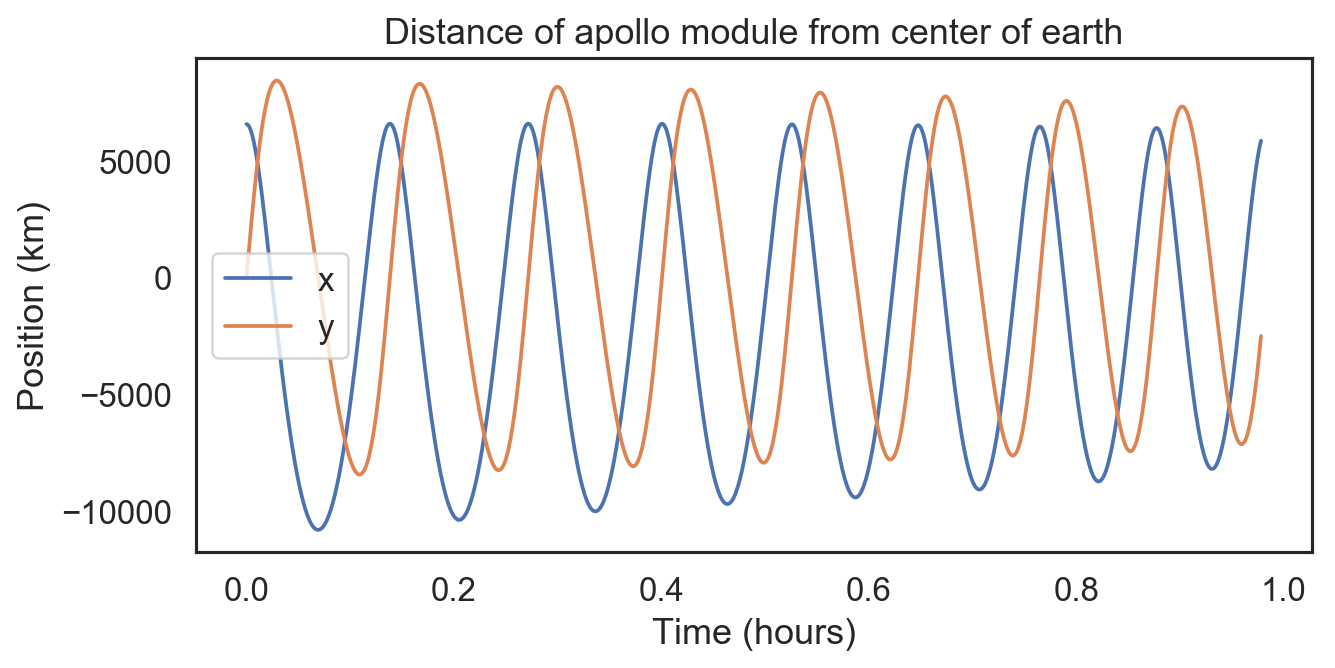

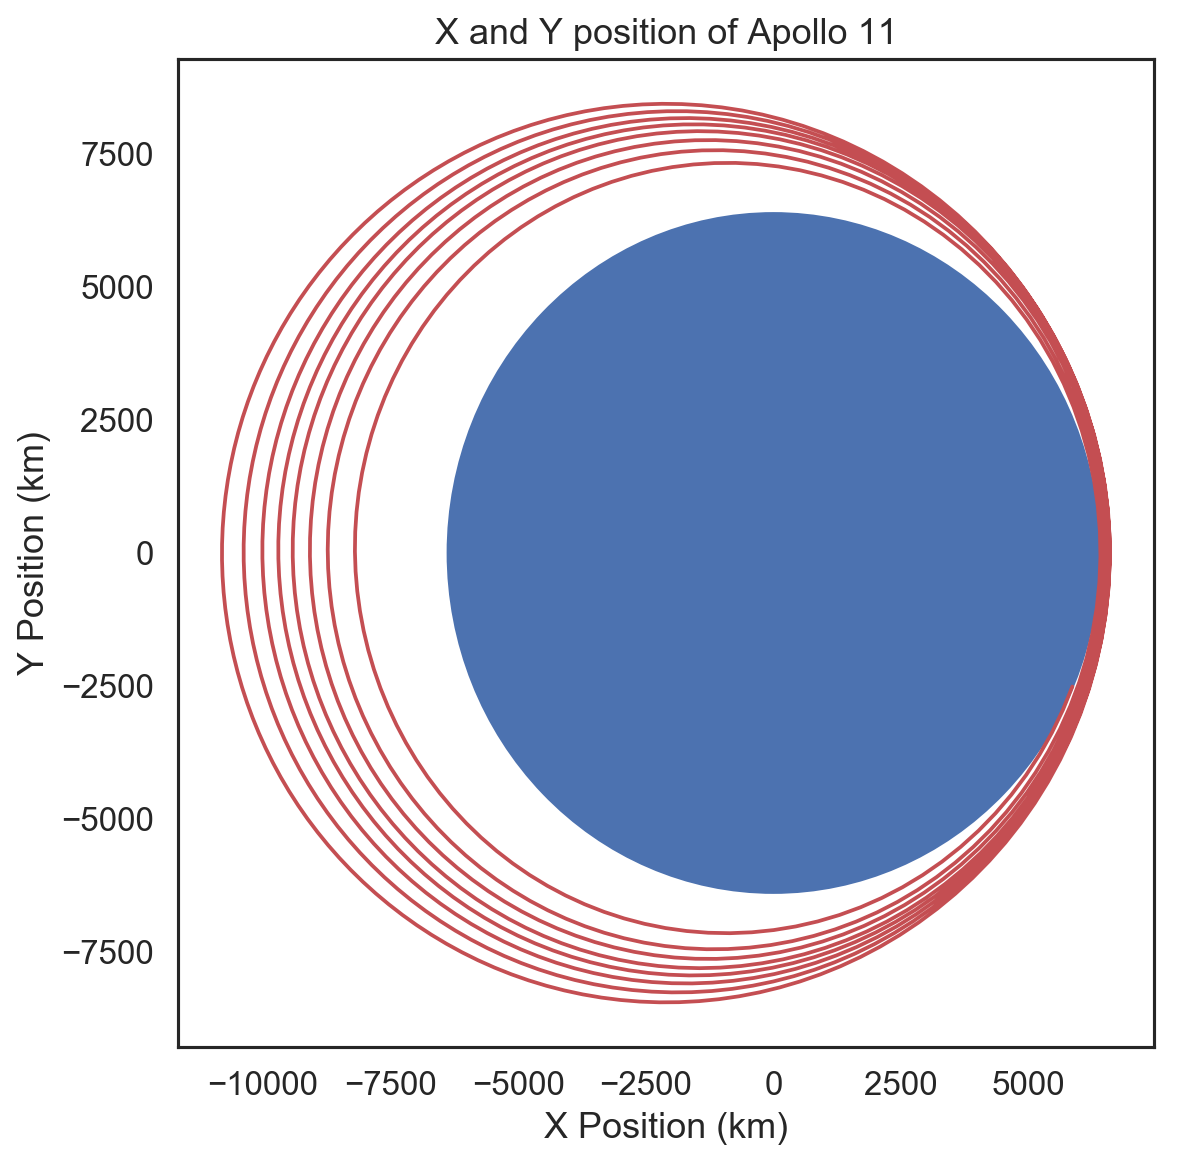

In [18]:
results_blah = run_simulation(8700);
plot1, plot2 = plot_orbit(results_blah, True, True)
revs(results_blah)

In [23]:
sweep = SweepSeries() #8000 - 9000
for i in linrange(8000, 8900, 10):
    results = run_simulation(i)
    sweep[i] = revs(results)

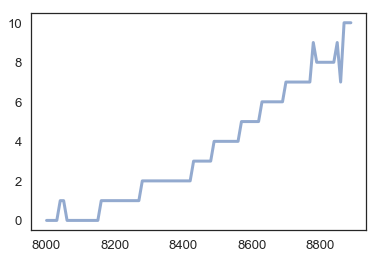

In [24]:
sweep
plot(sweep)

In [32]:
arr = np.where(sweep == 5)
arr[0][0]*10 + 8000

8570

In [36]:
print(sweep[8570])

5
